In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
from MNIST_helper import plot_numbers, visualize_input
import draw_nn

# Dataset Train, CV, Test

In [3]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

Using TensorFlow backend.


In [4]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


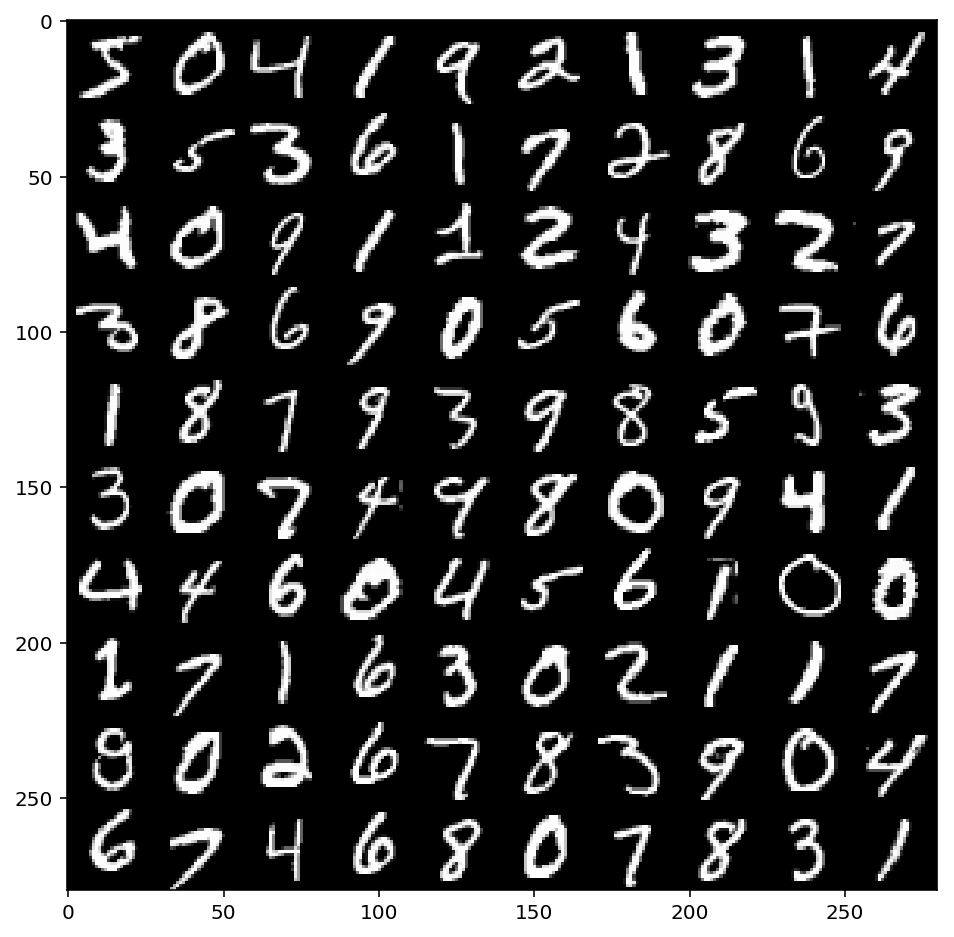

In [5]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

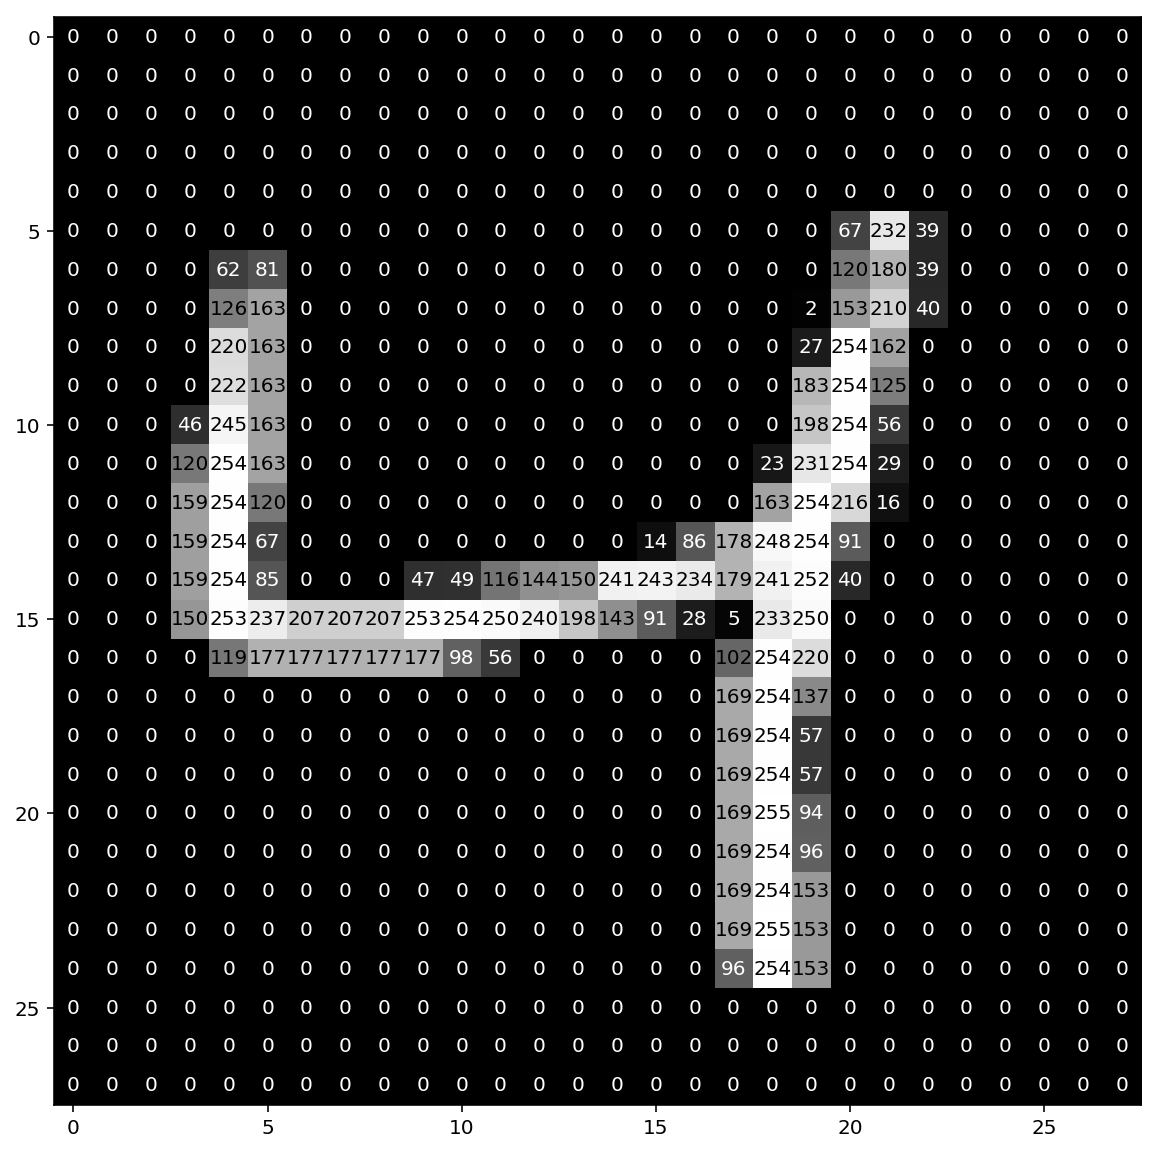

In [6]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[2], ax)
plt.show()

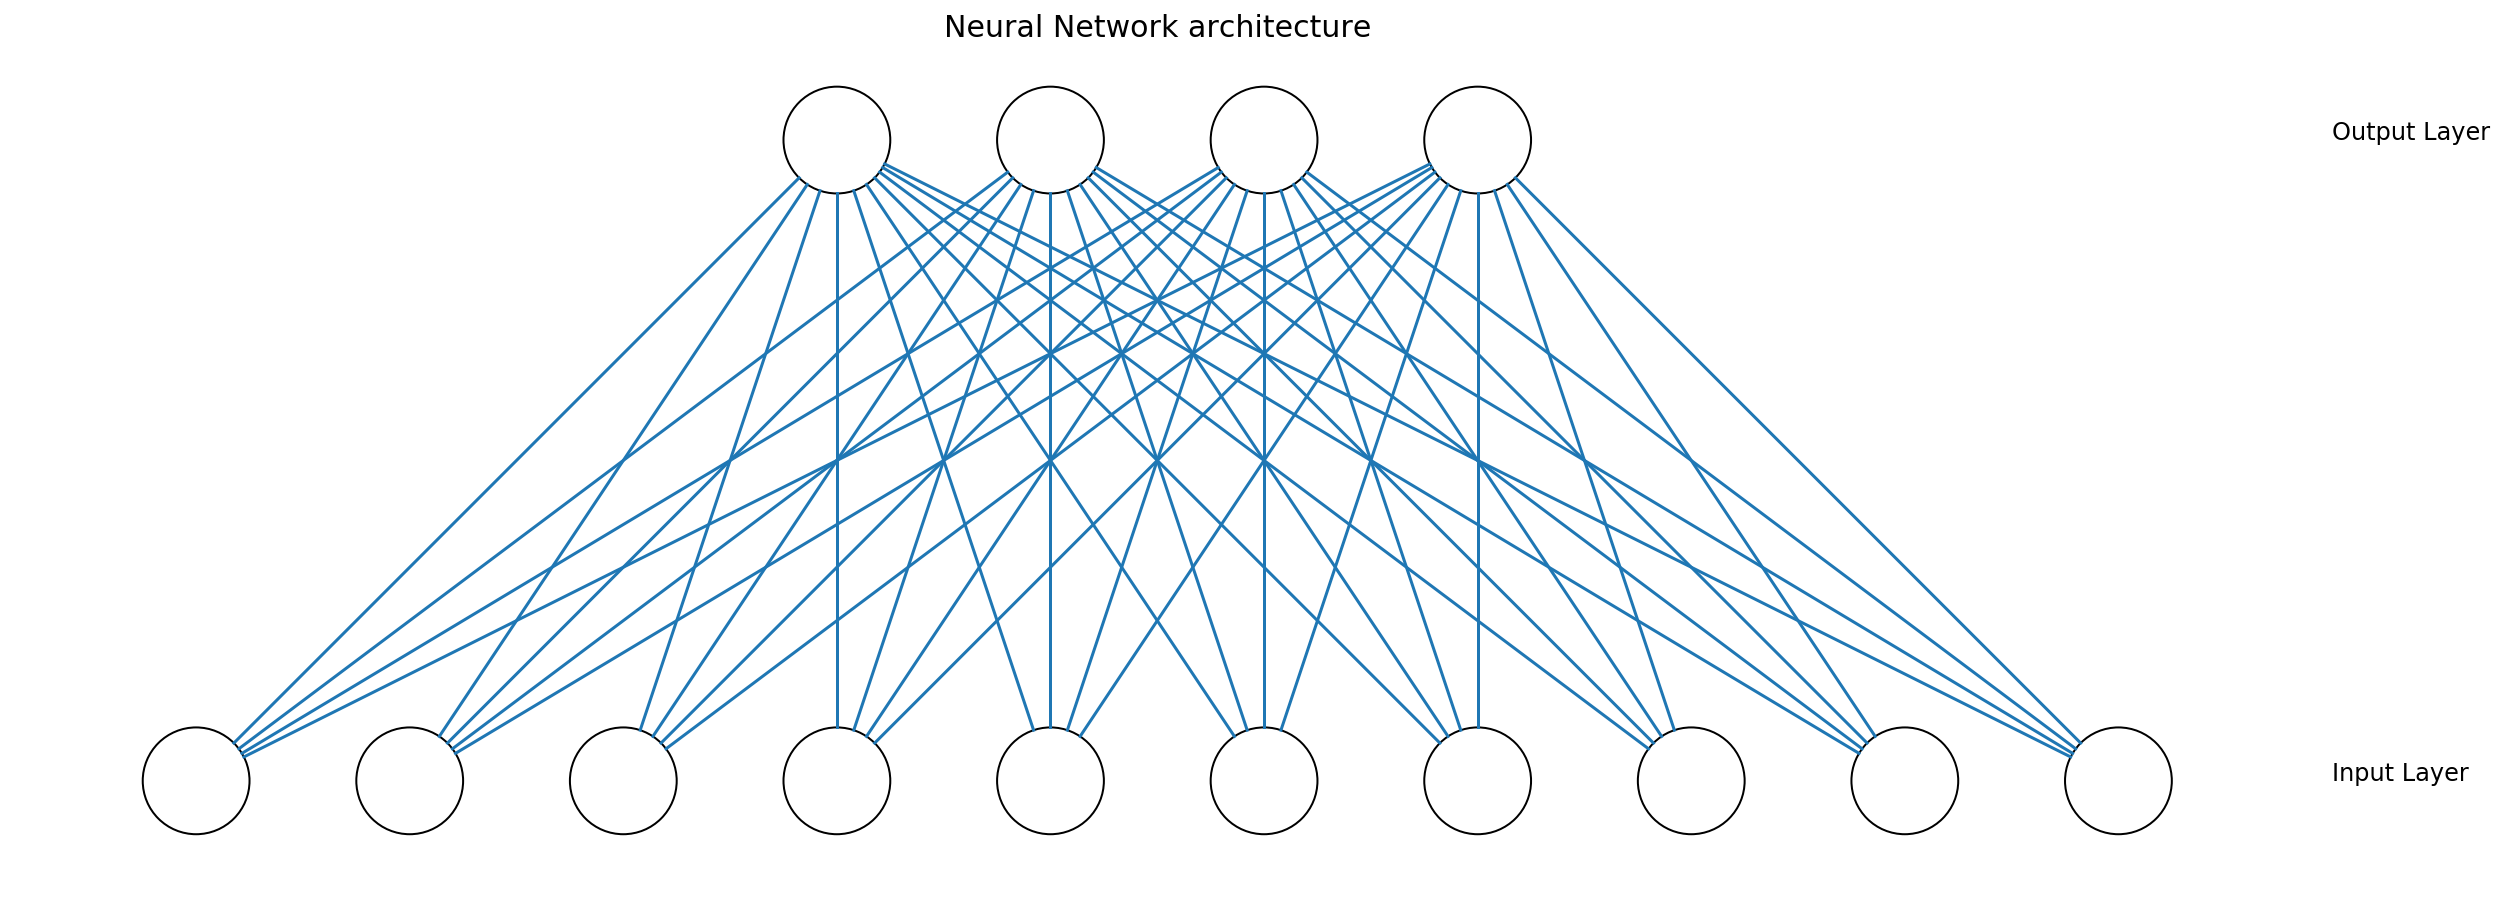

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [7]:
network = draw_nn.DrawNN( [10,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

# Paso salida a one-hot encoding

In [8]:
import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[0])

(48000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Multiples clases a la salida -> SoftMax

La suma de las probabilidades debe ser 1

Clases de 1 a 10  

\begin{equation}
\huge P(Clase\ 1 | X^{(i)}, \Theta) = \frac{e^{X^{(i)}\Theta_1}}{\sum_j{e^{X^{(i)}\Theta_j}}} 
\end{equation}

\begin{equation}
\huge P(Clase\ 2 | X^{(i)}, \Theta) = \frac{e^{X^{(i)}\Theta_2}}{\sum_j{e^{X^{(i)}\Theta_j}}} 
\end{equation}

\begin{equation}
\huge...
\end{equation}

\begin{equation}
\huge P(Clase\ 10 | X^{(i)}, \Theta) = \frac{e^{X^{(i)}\Theta_{10}}}{\sum_j{e^{X^{(i)}\Theta_j}}} 
\end{equation}

In [84]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

output_size = 10

# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:]))
model_single_layer.add(Dense(output_size, activation='softmax', kernel_initializer='zeros', name='Salida'))
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Compilo el modelo
import keras.optimizers as optimizers
opt = optimizers.SGD(lr = 0.00001)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Antes de entrenar

In [86]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.3025851249694824
accuracy:  0.098


Por que ese accuracy? Que pasa en el caso de solo 2 clases?

# Entrenamos

In [87]:
from fnn_helper import PlotLosses
from keras.callbacks import ModelCheckpoint 

plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')

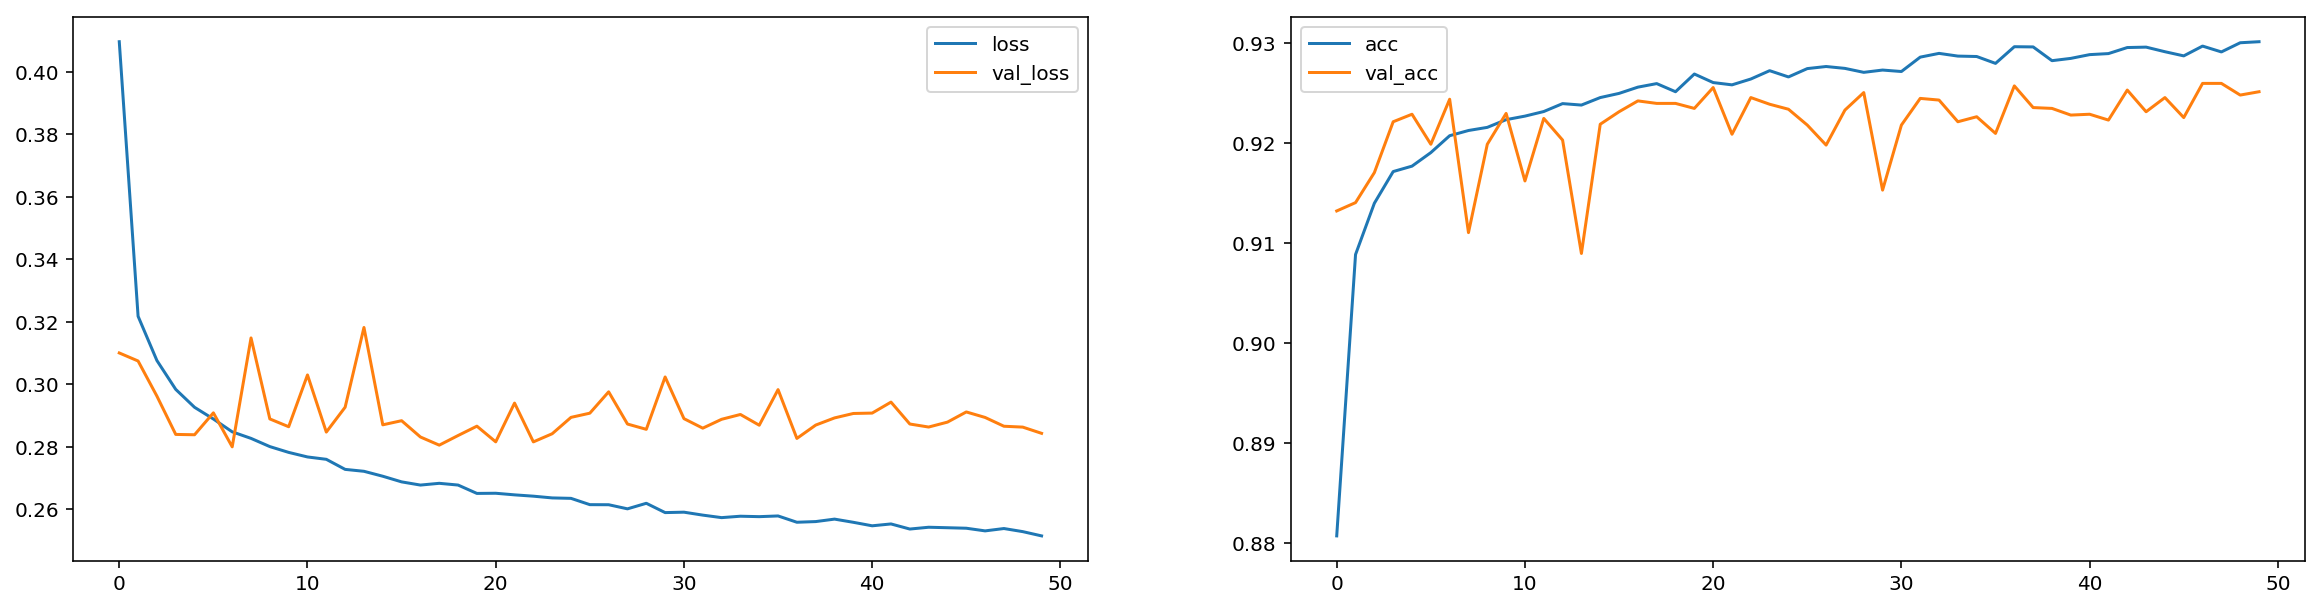


Epoch 00050: val_acc did not improve from 0.92592


In [88]:
batch_size = 100
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=50, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

Es muy sensible a la inicialización, al learning rate y al optimizador

Hacer pruebas cambiandolos

# La evaluación se hace en test

In [89]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.2863312340274453
accuracy:  0.9247


# Analisis de los pesos

In [90]:
import numpy as np
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)

(784, 10)
[-9.5725271e-05  1.1603294e-04  9.8411489e-05 -1.4294677e-04
  4.5405028e-05  6.9117837e-04 -5.8105175e-05  2.3053234e-04
 -7.1482308e-04 -1.6996035e-04]


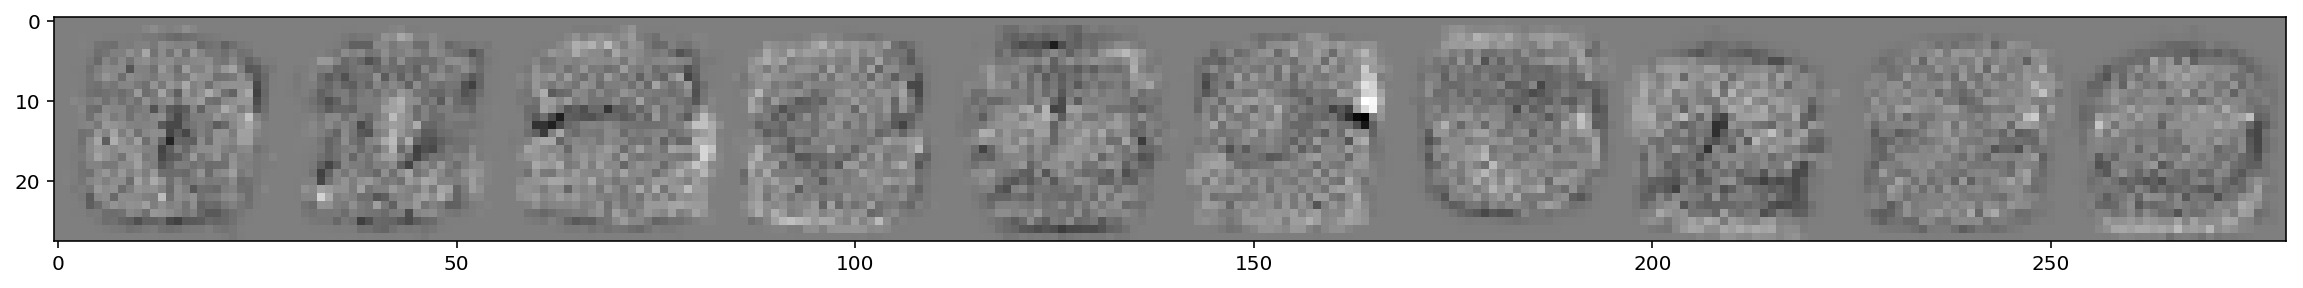

In [91]:
plt.figure(figsize=(20,20))
concatenated_weights = weights[:,0].reshape(28,28)
for wei in weights.T[1:10]:
    concatenated_weights = np.concatenate((concatenated_weights, wei.reshape(28,28)),axis=1 )
plt.imshow(concatenated_weights, cmap='gray')
plt.show()

# Analisis de dígitos errados

In [92]:
def get_errors(model, x_test, y_test):
    predicted = model.predict(x_test)
    predicted_numbers = predicted.argmax(axis=1)
    accuracy = (predicted_numbers==y_test).sum()/predicted_numbers.shape[0]
    error_indexes = np.where((predicted_numbers==y_test)==False)[0]
    error = error_indexes.shape[0]/predicted_numbers.shape[0]
    return accuracy, error, error_indexes, predicted_numbers
accuracy, error, error_indexes, predicted_numbers = get_errors(model_single_layer, x_test, y_test)
print(accuracy, error, accuracy + error)
print(predicted_numbers.shape)

0.9247 0.0753 1.0
(10000,)


[[5 7 9 4 2 5 9 6 4 3]
 [8 2 7 8 4 5 7 9 3 1]
 [5 1 6 7 9 4 7 0 7 9]
 [4 8 7 5 5 9 7 1 8 4]
 [9 2 5 3 4 7 2 3 9 7]
 [0 7 0 5 4 7 3 6 4 6]
 [9 3 9 9 9 4 2 2 9 6]
 [4 5 9 3 3 9 3 9 6 9]
 [1 5 8 7 7 7 3 9 6 5]
 [1 7 5 4 4 7 0 9 1 4]]
[[6 4 8 2 7 3 8 0 9 5]
 [2 7 3 9 9 8 9 7 5 3]
 [4 6 5 2 3 6 8 7 2 5]
 [9 3 8 6 3 7 3 5 7 2]
 [8 6 6 7 2 3 8 8 4 2]
 [9 9 4 3 9 1 8 1 9 1]
 [1 9 2 1 8 9 0 4 5 1]
 [9 3 4 2 2 7 5 1 8 3]
 [2 9 9 9 2 3 7 1 4 0]
 [4 2 6 9 6 2 6 4 3 2]]


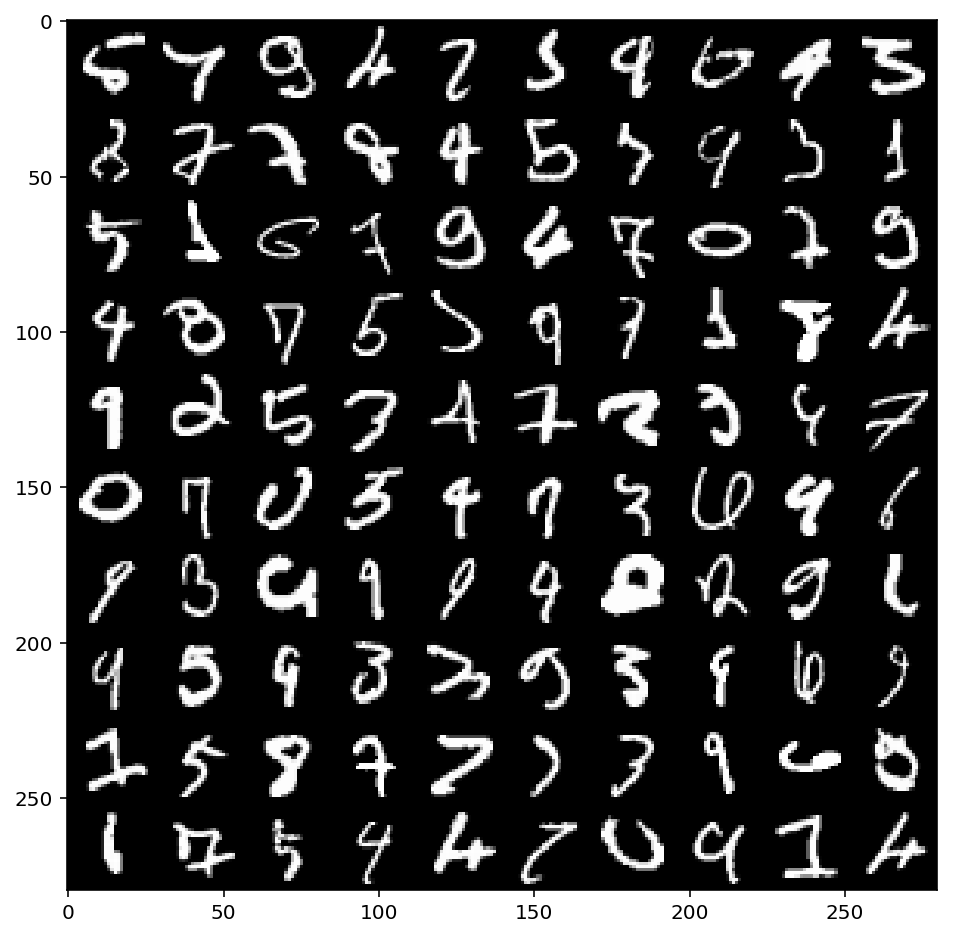

In [116]:
print(y_test[error_indexes[:100]].reshape(10,10))
print(predicted_numbers[error_indexes[:100]].reshape(10,10))
plot_numbers(x_test,error_indexes[:100], columns=10, figsize=(8, 8))

# Recupero los pesos guardados cuando la metrica era la mejor

In [94]:
# Cargo los valores del modelo
model_single_layer.load_weights('single-layer.mnist.hdf5')
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.287879440690577
accuracy:  0.9256


# Red neuronal de 2 capas

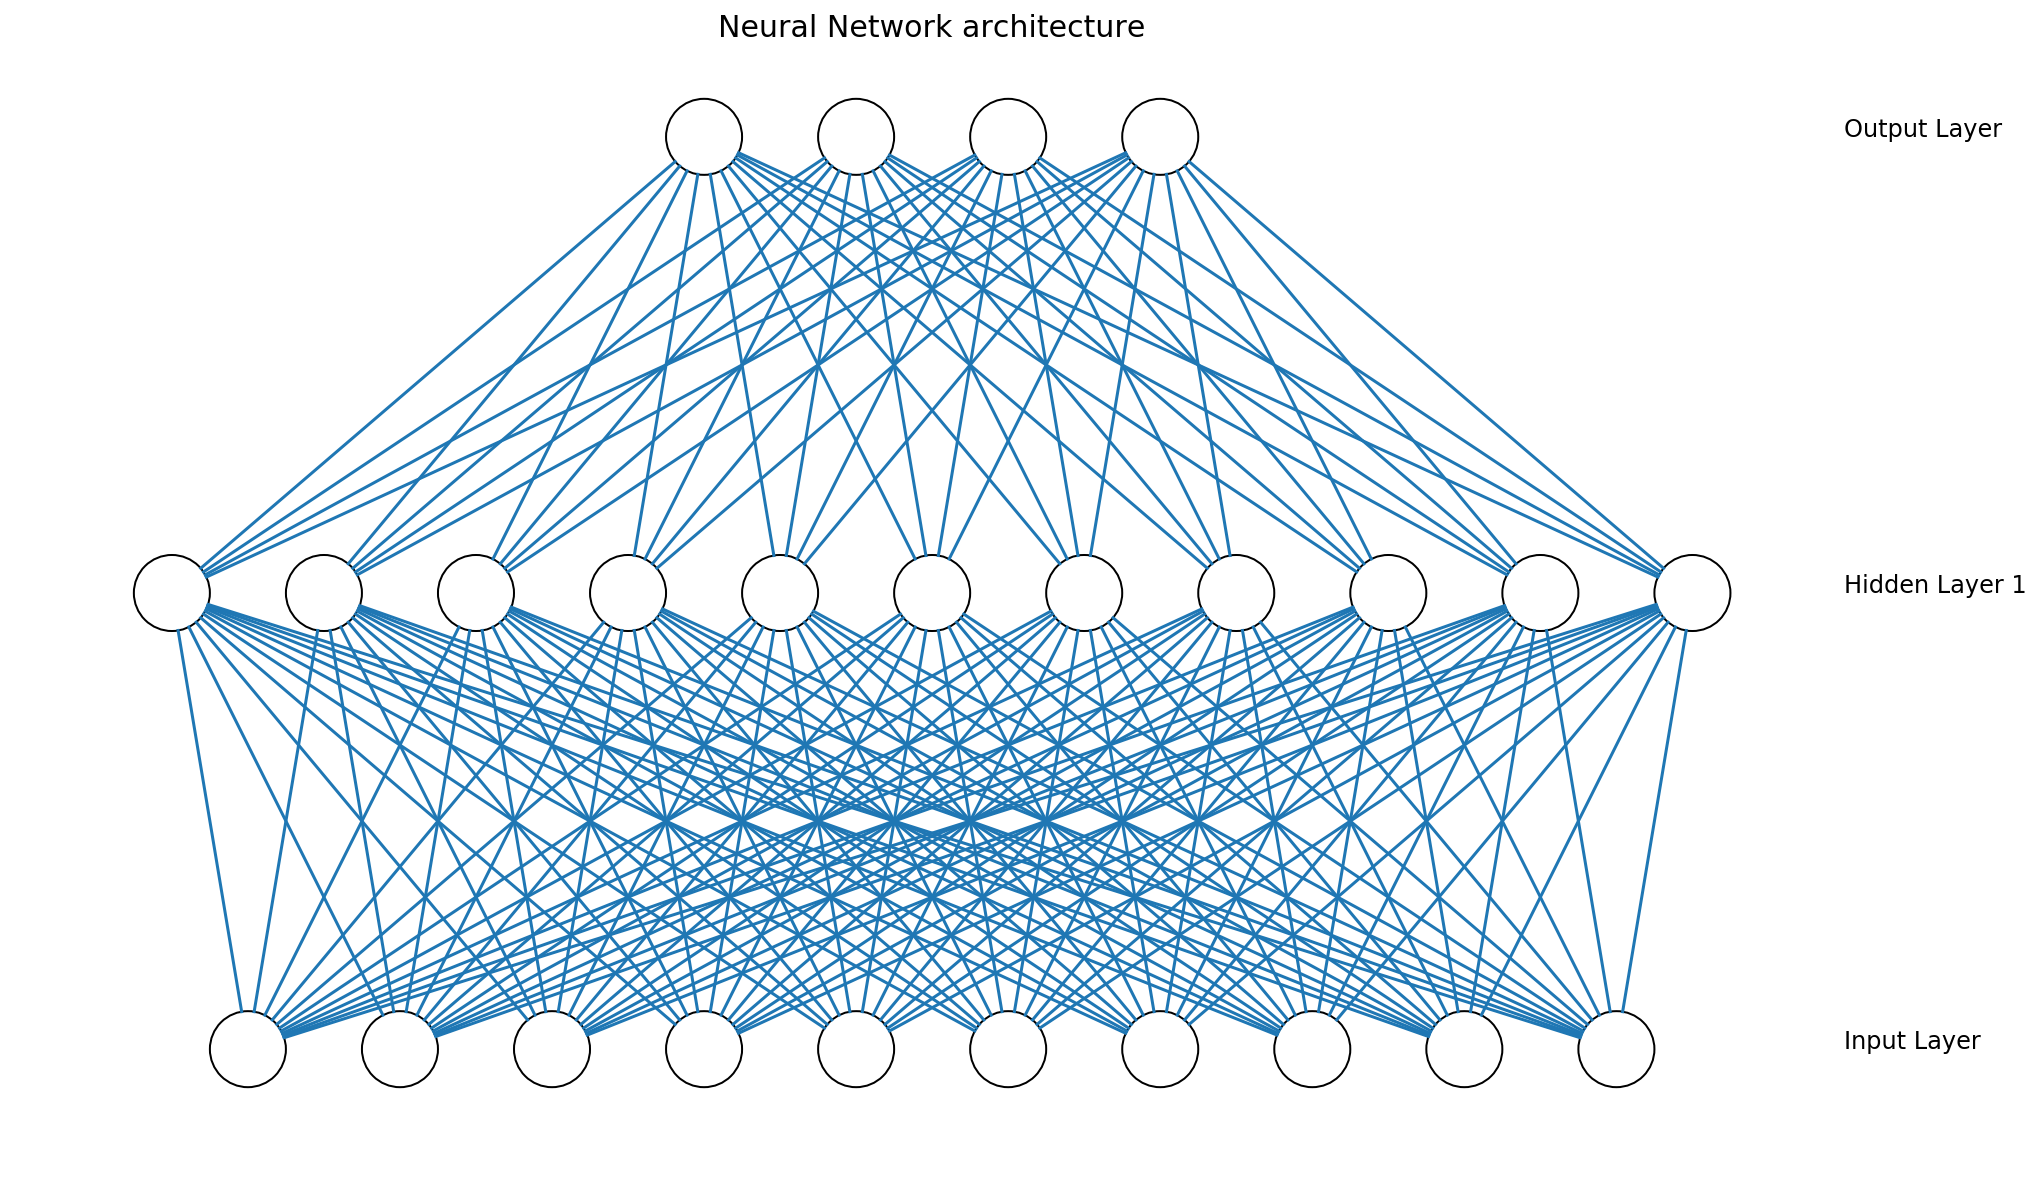

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [95]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

In [96]:
def two_layer_model(lr=0.000001, decay=0):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='zeros', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


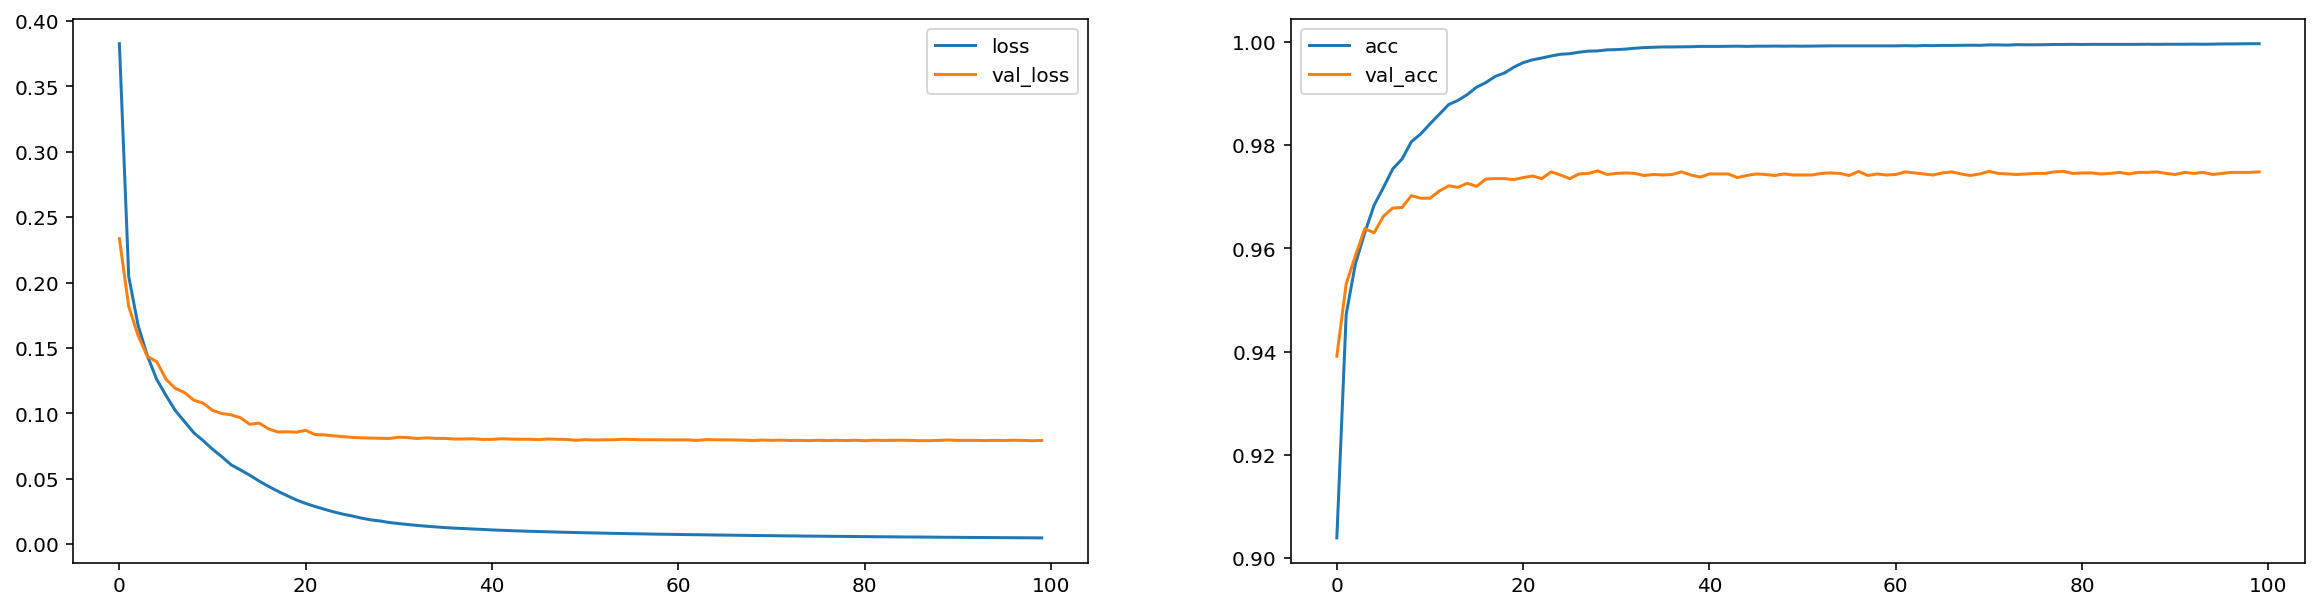

In [97]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers = two_layer_model(lr=0.01) # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

In [98]:
score = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.07914751294991001
accuracy:  0.9748


# Deep learning: Red neuronal de 4 capas ocultas

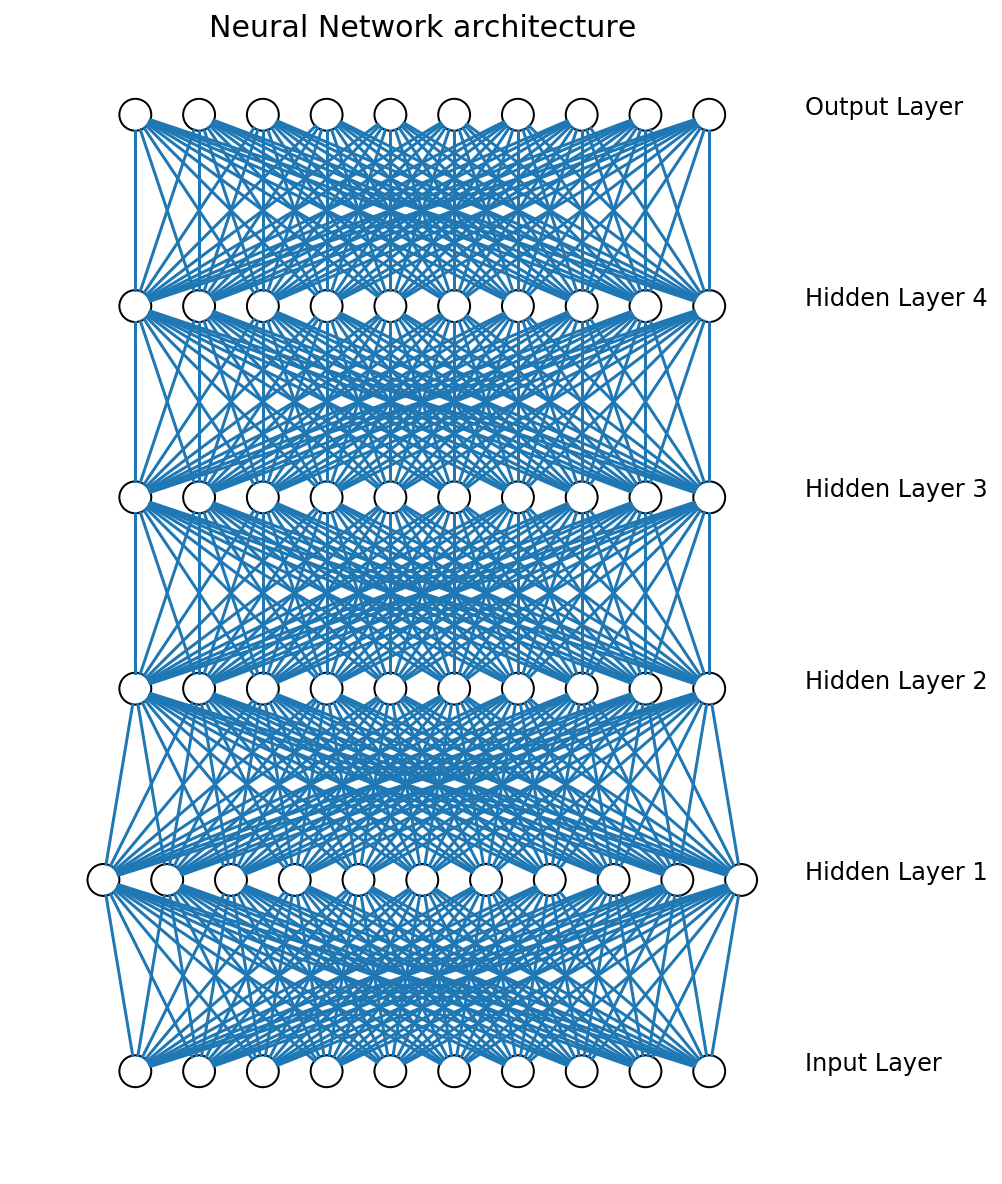

In [109]:
network = draw_nn.DrawNN( [10,11,10, 10, 10, 10] )
network.draw()

In [105]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [106]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

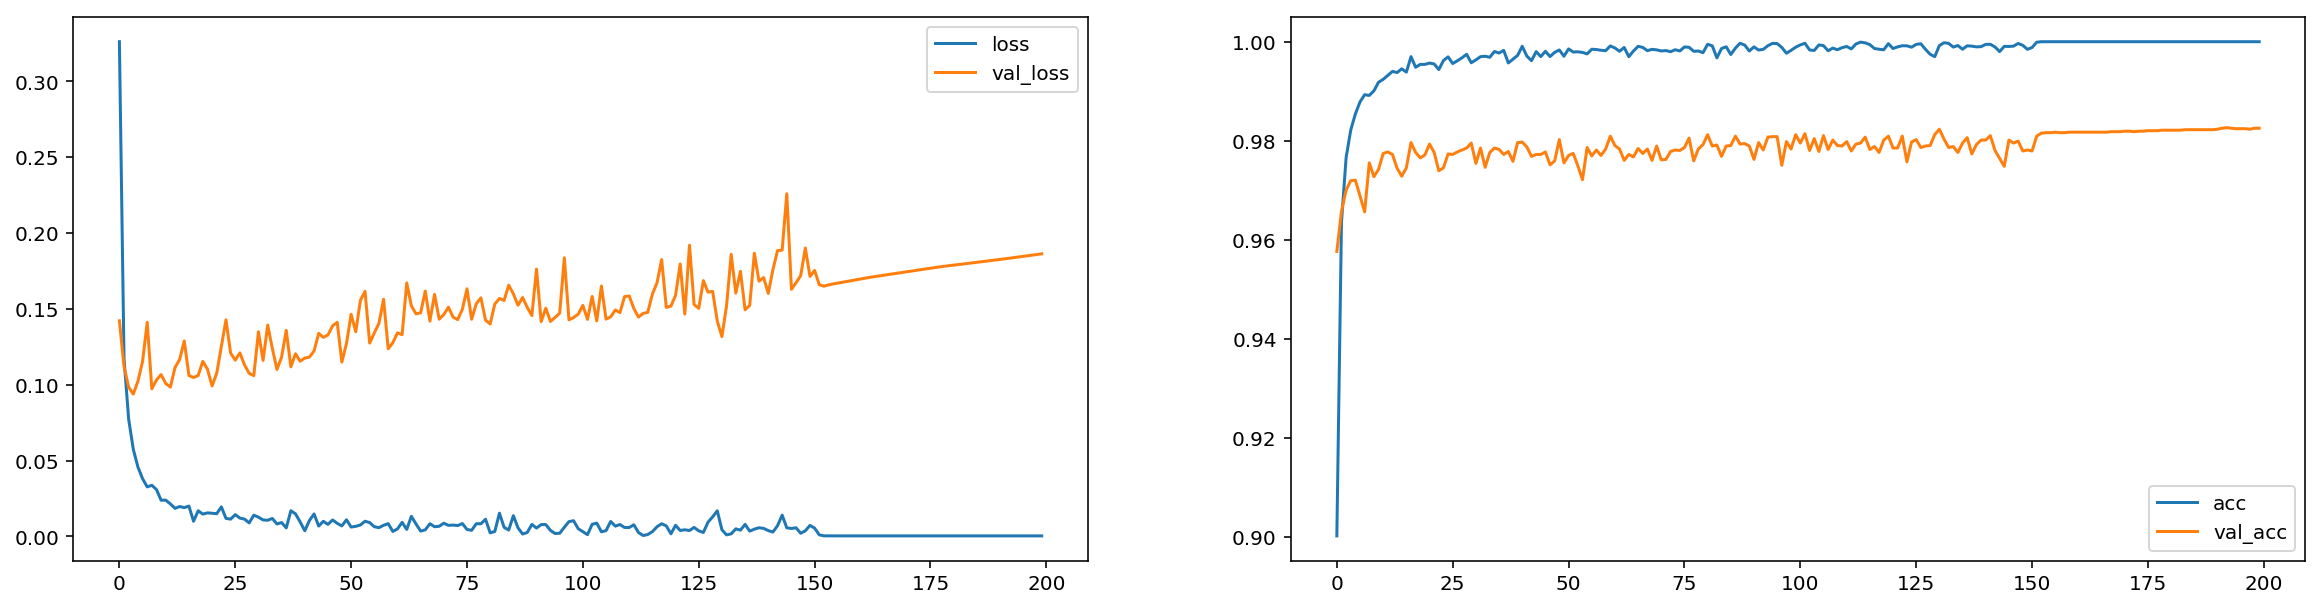


Epoch 00200: val_acc did not improve from 0.98260


In [107]:
checkpointer = ModelCheckpoint(filepath='5-layer.mnist.hdf5', verbose=1, save_best_only=True, monitor='val_acc')
model.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=200, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [108]:
score = model.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.1861769263044154
accuracy:  0.9825


In [111]:
accuracy, error, error_indexes, predicted_numbers = get_errors(model, x_test, y_test)
print(accuracy, error, accuracy + error)
print(predicted_numbers.shape)

0.9825 0.0175 1.0
(10000,)


[[5 7 9 4 2 5 9 6 4 3]
 [8 2 7 8 4 5 7 9 3 1]
 [5 1 6 7 9 4 7 0 7 9]
 [4 8 7 5 5 9 7 1 8 4]
 [9 2 5 3 4 7 2 3 9 7]
 [0 7 0 5 4 7 3 6 4 6]
 [9 3 9 9 9 4 2 2 9 6]
 [4 5 9 3 3 9 3 9 6 9]
 [1 5 8 7 7 7 3 9 6 5]
 [1 7 5 4 4 7 0 9 1 4]]
[[6 4 8 2 7 3 8 0 9 5]
 [2 7 3 9 9 8 9 7 5 3]
 [4 6 5 2 3 6 8 7 2 5]
 [9 3 8 6 3 7 3 5 7 2]
 [8 6 6 7 2 3 8 8 4 2]
 [9 9 4 3 9 1 8 1 9 1]
 [1 9 2 1 8 9 0 4 5 1]
 [9 3 4 2 2 7 5 1 8 3]
 [2 9 9 9 2 3 7 1 4 0]
 [4 2 6 9 6 2 6 4 3 2]]


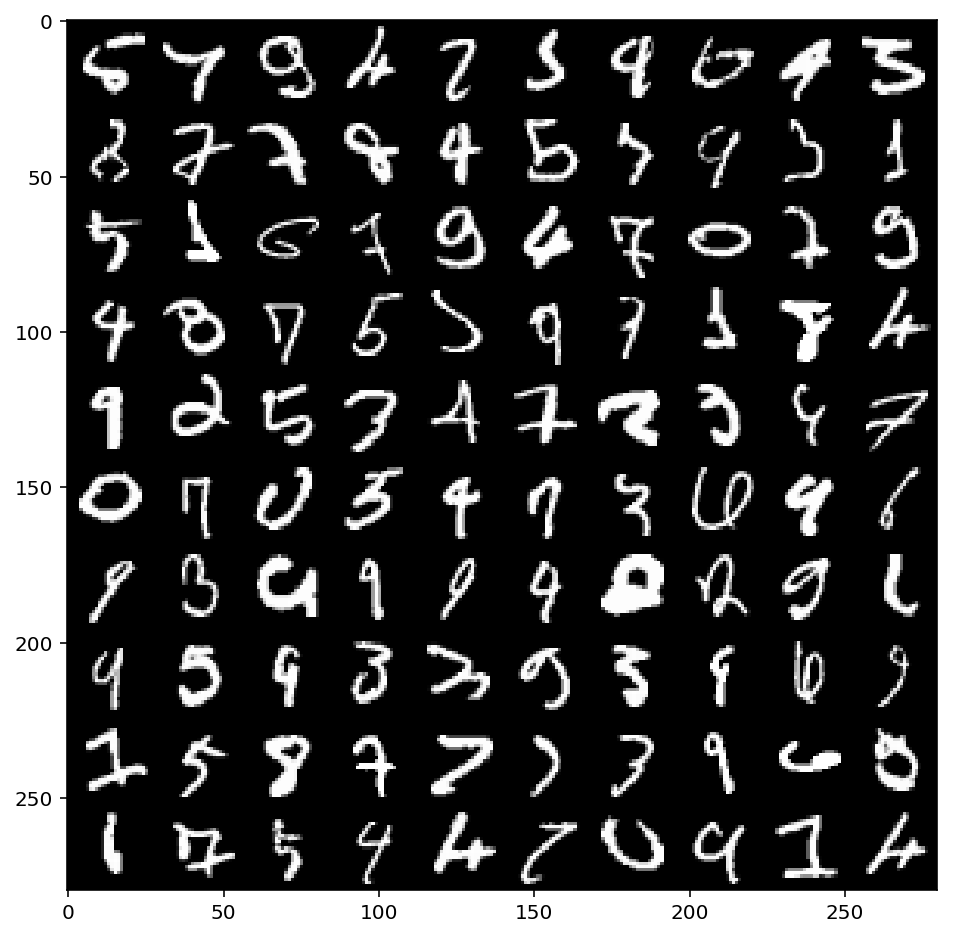

In [114]:
print(y_test[error_indexes[:100]].reshape(10,10))
print(predicted_numbers[error_indexes[:100]].reshape(10,10))
plot_numbers(x_test,error_indexes[:100], columns=10, figsize=(8, 8))

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros
- Se pierden las relaciones originales de los pixeles adyacentes (flatten). 